In [1]:
import matplotlib.pyplot as plt
from datasets.mathprim.marked_integer_dataset import MixedSprites3Dataset

train_dataset = MixedSprites3Dataset(dataset_size=1024)  # create a dataset with 1024 samples
test_dataset = MixedSprites3Dataset(dataset_size=128)  # create a dataset with 128 samples for testing
corpus = [data[1]["query"] for data in train_dataset]

#from data.collect_corpus import write_vocab, load_corpus, build_vocab
#vocab = build_vocab([] + corpus)
##write_vocab(vocab)


In [2]:
from core.model import MetaLearner
learner = MetaLearner([])
learner.load_ckpt("outputs/checkpoints/prototype")
### load the meta learner from the pretrained-checkpoint
pass


15 23:50:11 WRN The input domain is empty, creating an empty domain
15 23:50:11 WRN The input domain is empty, creating an empty domain
15 23:50:11 Function one automatically registered.
15 23:50:11 Function two automatically registered.
15 23:50:11 Function three automatically registered.
15 23:50:11 Function plus automatically registered.
15 23:50:11 Function avg automatically registered.
15 23:50:11 Function smaller automatically registered.
15 23:50:11 Function bigger automatically registered.
15 23:50:11 Function N automatically registered.
15 23:50:11 Function Z automatically registered.
15 23:50:11 Function subset automatically registered.
15 23:50:11 Function exists automatically registered.
15 23:50:11 Function forall automatically registered.
15 23:50:11 Function iota automatically registered.
15 23:50:11 Function negate automatically registered.
15 23:50:11 Function logic_and automatically registered.
15 23:50:11 Function logic_or automatically registered.
15 23:50:11 Functi

# Base Knowledge Learning


15 23:50:11 Filter dataset None: #before=1024, #after=532.
15 23:50:11 Filter dataset None: #before=128, #after=75.


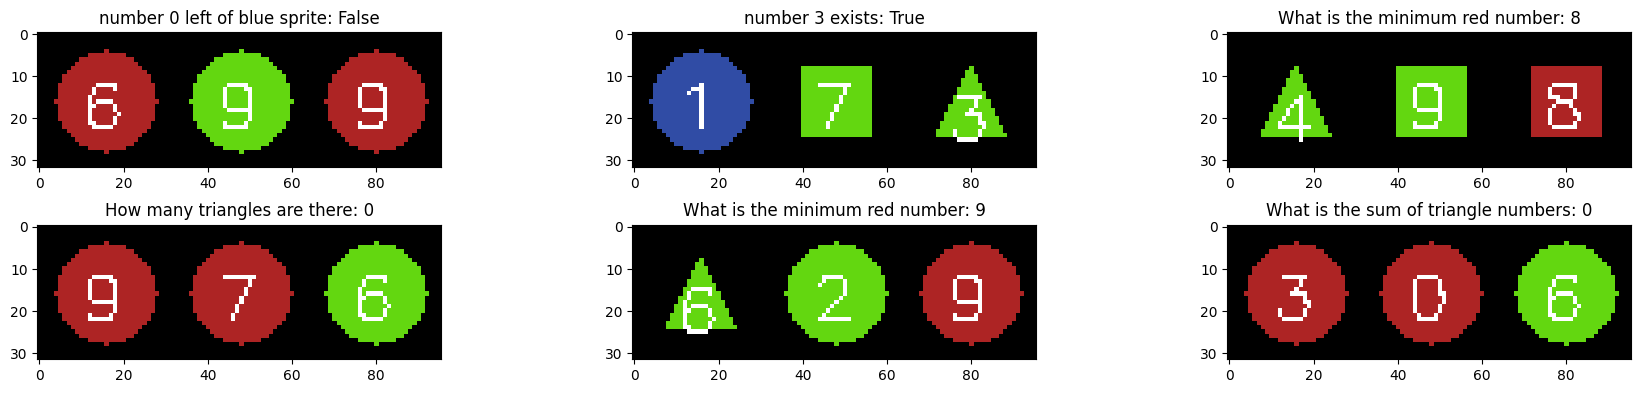

15 23:50:11 start to learn the words ['exists', 'circle'], add corpus size 35
Training epochs:  20%|██        | 20/100 [01:44<07:13,  5.42s/epoch, avg_loss=nan, avg_acc=0.4958]  

In [ ]:
from core.learn import AutoLearnSchedule
train_logic_dataset = train_dataset.filter(lambda x : x["question_type"] == "boolean")
test_logic_dataset = test_dataset.filter(lambda x : x["question_type"] == "boolean")

# Now let's visualize a few samples from the dataset:


plt.figure(figsize=(18, 4))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(train_dataset[i]['image'].permute(1, 2, 0).numpy()[..., ::-1] * 0.5 + 0.5)
    plt.title(train_dataset[i]['query'] + ': ' + str(train_dataset[i]['answer']))
    #stprint(train_dataset[i])
plt.tight_layout()
plt.show()

schedule = AutoLearnSchedule(train_logic_dataset)
schedule.procedual_train(learner)

In [ ]:
#learner.save_ckpt("outputs/checkpoints/s3d") # avg_loss=0.2669, avg_acc=0.5176


In [ ]:
from helchriss.dsl.dsl_types import BOOL

image = train_dataset[0]['image']
plt.imshow(image.permute(1, 2, 0).numpy()[..., ::-1] * 0.5 + 0.5)
learner.execute_display("exists triangle", grounding = {"image":image}, tp = BOOL,  topK = 10)

In [ ]:
for (entry, weight) in learner.maximal_parse("exists circle", tp = BOOL):print(entry, weight)

# Continual Learning Concepts
MetaLearner can continually learning new concepts using only language description of the new word and the related domain entries.

In [ ]:
### Continual Learning of New Concepts
import matplotlib.pyplot as plt
from datasets.mathprim.marked_integer_dataset import MixedSprites3Dataset

train_dataset = MixedSprites3Dataset(dataset_size=1024)  # create a dataset with 1024 samples
test_dataset = MixedSprites3Dataset(dataset_size=128)  # create a dataset with 128 samples for testing
corpus = [data[1]["query"] for data in train_dataset]

#from data.collect_corpus import write_vocab, load_corpus, build_vocab
#vocab = build_vocab([] + corpus)
##write_vocab(vocab)

train_arith_dataset = train_dataset.filter(lambda x : x["question_type"] in ['boolean', "arithmetic"])
test_arith_dataset = test_dataset.filter(lambda x : x["question_type"] in ['boolean', "arithmetic"])

plt.figure(figsize=(18, 4))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(train_dataset[i]['image'].permute(1, 2, 0).numpy()[..., ::-1] * 0.5 + 0.5)
    plt.title(train_dataset[i]['query'] + ': ' + str(train_dataset[i]['answer']))
    #stprint(train_dataset[i])
plt.tight_layout()
plt.show()


In [ ]:
from core.metaphors.types import *
from helchriss.dsl.dsl_types import FLOAT

if __name__ == "__main__":
    # 1. 定义初始类型和目标类型
    # 初始类型：List[Vector[float, 3]]
    initial_type = ListType(
        element_type=VectorType(elem_type=FLOAT, dim=3)
    )
    # 目标类型：List[Embedding["vec3", 3]]
    target_type = ListType(
        element_type=EmbeddingType(space_name="vec3", dim=3)
    )

    # 2. 定义转换规则：将Vector[float, d]转换为Embedding["vec3", d]
    # 模式：List[Vector[float, $d]]（$d是变量，匹配维度）
    rule_pattern = ListType(
        element_type=VectorType(elem_type=FLOAT, dim=PatternVar("$d"))  # $d匹配任意维度
    )
    # 转换函数：用绑定的$d生成Embedding
    def vec_to_embedding(bindings: Dict[str, TypeBase]) -> TypeBase:
        d = bindings["d"]  # $d绑定的是Vector的dim（int）
        return ListType(
            element_type=EmbeddingType(space_name="vec3", dim=d)
        )
    transform_rule = TransformRule(
        pattern=rule_pattern,
        transform_func=vec_to_embedding
    )

    # 3. 查找转换路径
    path = find_transform_path(
        initial_type=initial_type,
        target_type=target_type,
        rules=[transform_rule],
        max_depth=3
    )

    # 4. 输出结果
    if path:
        print(f"找到从 {initial_type} 到 {target_type} 的转换路径：")
        for i, (rule, bindings) in enumerate(path):
            print(f"步骤{i+1}：应用规则，变量绑定：")
            for var, typ in bindings.items():
                print(f"  ${var} = {typ}")
    else:
        print(f"无法从 {initial_type} 转换到 {target_type}")





In [ ]:
from helchriss.dsl.dsl_types import BOOL

initial_type = ListType(
        element_type=TupleType([EmbeddingType("set", 128), BOOL])
    )

target_type = ListType(
        element_type=TupleType([PatternVar("$d"), BOOL])
    )

matches = match_pattern(initial_type, target_type)

if matches is not None:
    for var in matches:print(var, matches[var])
else:print("No Match Found")